<div align="center">

# Readmissions Predictor

<img src="https://cdn.ibj.com/wp-content/uploads/2021/11/Focus_hospital_111921.jpg" alt="Hospital Image" width="600"/>

</div>


This notebook presents a case study to develop a machine learning model capable of predicting the risk of 30-day hospital readmission using demographic, clinical, and administrative variables from a multi-hospital dataset covering over 100,000 diabetic patient encounters in the United States.

The aim is to assist healthcare providers in identifying high-risk patients and optimizing post-discharge planning, ultimately improving care continuity and reducing preventable readmissions.

<h3 style="text-align:center">Data Sourcing</h3>

UCI Machine Learning Repository – Diabetes 130-US hospitals for years 1999–2008  

[Dataset Link](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008)


<h3 style="text-align:center">Data Description</h3>

This dataset represents 10 years (1999–2008) of clinical care at 130 U.S. hospitals and integrated delivery networks. It contains over 100,000 hospital admissions for diabetic patients.



In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost statsmodels

# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

<h3 style="text-align:center">Data Collection</h3>

The data will be extracted with a pandas library, a subset of the data will be selected to ensure efficient processing and focus.


In [ ]:
# Data collection

# Load dataset, create dataframe, examine first rows

#1. Define the GitHub raw CSV URL
csv_url = 'https://raw.githubusercontent.com/Mel-brenes/Readmissions-Predictor/refs/heads/main/diabetic_data.csv'

#2. Load the dataset
df = pd.read_csv(csv_url)

#3. Limit to the first 10,000 rows for faster experimentation
df = df.head(10000)

#4. Display the first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No

<h3 style="text-align:center">Data Cleansing</h3>

We will create a dataframe, delete duplicates, and remove unnecesary columns.


In [ ]:
# Data cleansing

# 1. Remove duplicate rows
df = df.drop_duplicates()

# 2. Show data types for each column
print("\nData types of each column:")
print(df.dtypes)



Data types of each column:
encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide             

In [ ]:
# 3. Show count of missing or unknown values per column
# In this dataset, many missing values are marked as '?' rather than NaN
print("\nMissing or unknown values per column ('?'):")
missing_counts = (df == '?').sum()
print(missing_counts[missing_counts > 0])


Missing or unknown values per column ('?'):
race                   184
weight                9725
payer_code           10000
medical_specialty     3629
diag_1                   6
diag_2                  63
diag_3                 300
dtype: int64


In [ ]:
# 4. Remove irrelevant, low-value, or low-variance columns

# Define known low-value columns (too many missing values or irrelevant)
high_missing_or_irrelevant = [
    'weight',               # 97% missing
    'payer_code',           # 100% missing
    'medical_specialty',    # 36% missing and highly categorical
    'examide',              # All values are 'No'
    'citoglipton',          # All values are 'No'
    'max_glu_serum',        # 91% missing, limited interpretability
    'A1Cresult'             # 81% missing, rarely meaningful
]

# Define ID columns (not useful for prediction)
identifiers = [
    'encounter_id', 'patient_nbr'
]

# Drug columns with extremely low variability (mostly 'No' or single value)
low_variability_drugs = [
    'acetohexamide', 'tolbutamide', 'troglitazone', 'miglitol', 'tolazamide',
    'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]

# Combine all into one list
columns_to_drop = high_missing_or_irrelevant + identifiers + low_variability_drugs

# Drop only if they exist in the dataframe
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Show updated shape and remaining columns
print(f"\n Columns after dropping low-value features: {len(df.columns)}")
print(df.columns.tolist())


 Columns after dropping low-value features: 31
['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin', 'change', 'diabetesMed', 'readmitted']


In [ ]:
# 5. Handle missing values marked as '?' and impute or fill NaNs

# Replace all '?' strings with np.nan
df.replace('?', np.nan, inplace=True)

# Impute numerical columns with their median
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = df[col].fillna(df[col].median())

# Impute/fill categorical columns with appropriate placeholders
categorical_fills = {
    'race': 'Unknown',
    'diag_1': 'Missing',
    'diag_2': 'Missing',
    'diag_3': 'Missing'
}

for col, fill_value in categorical_fills.items():
    if col in df.columns:
        df[col] = df[col].fillna(fill_value)

# Verify remaining missing values
print("\n Remaining missing values after full cleaning:")
print(df.isnull().sum()[df.isnull().sum() > 0])




 Remaining missing values after full cleaning:
Series([], dtype: int64)


In [ ]:
# 6. Ensure target column exists
if 'readmitted_binary' not in df.columns:
    if 'readmitted' in df.columns:
        df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
        df.drop(columns='readmitted', inplace=True)
        print(" Target column 'readmitted_binary' created.")
    else:
        print(" Neither 'readmitted' nor 'readmitted_binary' found — target not created.")


 Target column 'readmitted_binary' created.


<h3 style="text-align:center">Data Preprocessing</h3>

In this section, we will manipulate the new data frame to create new columns and preprocess data for training the models later on.

In [ ]:
# 1: Encode categorical variables and prepare target column

from sklearn.preprocessing import LabelEncoder

# Identify all categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
print("\nCategorical columns to encode:")
print(categorical_cols)

# Encode binary categorical features using LabelEncoder
binary_cols = [col for col in categorical_cols if df[col].nunique() == 2]

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# One-hot encode non-binary categorical features with low cardinality
low_card_cols = [
    col for col in categorical_cols
    if col not in binary_cols and 3 <= df[col].nunique() <= 10
]

df = pd.get_dummies(df, columns=low_card_cols, drop_first=True)

# Create binary target column if 'readmitted' exists
if 'readmitted' in df.columns:
    df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
    df.drop(columns='readmitted', inplace=True)
    print("\n'readmitted_binary' created and 'readmitted' column dropped.")
else:
    print("\n'readmitted' column not found — assuming 'readmitted_binary' already exists.")

# Identify unencoded high-cardinality categorical columns
high_card_cols = [
    col for col in categorical_cols
    if col not in binary_cols + low_card_cols
]

if high_card_cols:
    print("\nColumns with high cardinality not yet encoded:")
    print(high_card_cols)
else:
    print("\nAll categorical variables successfully encoded.")



Categorical columns to encode:
['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin', 'change', 'diabetesMed']

'readmitted' column not found — assuming 'readmitted_binary' already exists.

Columns with high cardinality not yet encoded:
['diag_1', 'diag_2', 'diag_3']


In [ ]:
# 2. Check point for high cardinality variables: Inspect a sample of diagnosis codes from each column
print("\n Sample diag_1 values:")
print(df['diag_1'].unique()[:20])

print("\n Sample diag_2 values:")
print(df['diag_2'].unique()[:20])

print("\n Sample diag_3 values:")
print(df['diag_3'].unique()[:20])



 Sample diag_1 values:
['250.83' '276' '648' '8' '197' '414' '428' '398' '434' '250.7' '157'
 '518' '999' '410' '682' '402' '737' '572' 'V57' '189']

 Sample diag_2 values:
['Missing' '250.01' '250' '250.43' '157' '411' '492' '427' '198' '403'
 '288' '998' '507' '174' '425' '456' '401' '715' '496' '428']

 Sample diag_3 values:
['Missing' '255' 'V27' '403' '250' 'V45' '38' '486' '996' '197' '250.6'
 '427' '627' '414' '416' '714' '428' '582' 'V43' '250.01']


In [ ]:
# 3. Group diagnosis codes into broad clinical categories

def map_diag(code):
    if pd.isna(code):
        return 'Other'
    try:
        code = str(code)
        if code.startswith('V') or code.startswith('E'):
            return 'Other'  # Special ICD-9 V/E codes
        code = float(code)
    except:
        return 'Other'

    if (390 <= code <= 459) or code == 785:
        return 'Circulatory'
    elif (460 <= code <= 519) or code == 786:
        return 'Respiratory'
    elif (520 <= code <= 579) or code == 787:
        return 'Digestive'
    elif (250 <= code < 251):
        return 'Diabetes'
    elif (800 <= code <= 999):
        return 'Injury'
    elif (710 <= code <= 739):
        return 'Musculoskeletal'
    elif (580 <= code <= 629):
        return 'Genitourinary'
    elif (140 <= code <= 239):
        return 'Neoplasms'
    else:
        return 'Other'

# Apply mapping to all three diagnosis columns
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].apply(map_diag)

# Check new unique values
print("\n Diagnosis columns after grouping (updated):")
for col in ['diag_1', 'diag_2', 'diag_3']:
    print(f"{col}: {df[col].unique()}")


 Diagnosis columns after grouping (updated):
diag_1: ['Diabetes' 'Other' 'Neoplasms' 'Circulatory' 'Respiratory' 'Injury'
 'Musculoskeletal' 'Digestive' 'Genitourinary']
diag_2: ['Other' 'Diabetes' 'Neoplasms' 'Circulatory' 'Respiratory' 'Injury'
 'Musculoskeletal' 'Genitourinary' 'Digestive']
diag_3: ['Other' 'Circulatory' 'Diabetes' 'Respiratory' 'Injury' 'Neoplasms'
 'Genitourinary' 'Musculoskeletal' 'Digestive']


In [ ]:
#4. One-hot encode grouped diagnosis columns

# Diagnosis columns now have grouped categories like 'Diabetes', 'Circulatory', etc.
diag_cols = ['diag_1', 'diag_2', 'diag_3']

# Apply one-hot encoding
df = pd.get_dummies(df, columns=diag_cols, prefix=diag_cols, drop_first=True)

# Show updated shape and feature list preview
print(f"\n Data shape after encoding diagnosis columns: {df.shape}")
print(" Encoded diagnosis features preview:")
print([col for col in df.columns if col.startswith('diag_')])


 Data shape after encoding diagnosis columns: (10000, 83)
 Encoded diagnosis features preview:
['diag_1_Diabetes', 'diag_1_Digestive', 'diag_1_Genitourinary', 'diag_1_Injury', 'diag_1_Musculoskeletal', 'diag_1_Neoplasms', 'diag_1_Other', 'diag_1_Respiratory', 'diag_2_Diabetes', 'diag_2_Digestive', 'diag_2_Genitourinary', 'diag_2_Injury', 'diag_2_Musculoskeletal', 'diag_2_Neoplasms', 'diag_2_Other', 'diag_2_Respiratory', 'diag_3_Diabetes', 'diag_3_Digestive', 'diag_3_Genitourinary', 'diag_3_Injury', 'diag_3_Musculoskeletal', 'diag_3_Neoplasms', 'diag_3_Other', 'diag_3_Respiratory']


<h3 style="text-align:center">Feature Engineering</h3>

We will create several new features to enhance the predictive power of the model:

- **Total Prior Visits**: Sum of inpatient, emergency, and outpatient visits to reflect the overall care burden.  
- **High Medication Load Flag**: A binary indicator set to 1 if the patient is prescribed more than 20 medications.  
- **Polypharmacy Ratio**: Ratio of number of medications to number of diagnoses, indicating treatment complexity.  
- **Long Hospital Stay Flag**: A binary flag set to 1 if the patient stayed in the hospital for more than 7 days.  
- **Comorbidity Count**: Count of distinct diagnosis categories across the first three diagnosis codes (diag_1, diag_2, diag_3).  
- **Chronic Insulin Use**: Binary flag derived from the `insulin` column, where 'Up' or 'Steady' is mapped to 1, and other values to 0.

In [ ]:
# 1. Feature Engineering

# Total prior visits
df['total_prior_visits'] = df['number_inpatient'] + df['number_emergency'] + df['number_outpatient']

# High medication load flag
df['high_med_load'] = (df['num_medications'] > 20).astype(int)

# Polypharmacy ratio (handle div/0 + warning fix)
df['meds_per_diagnosis'] = df['num_medications'] / df['number_diagnoses']
df['meds_per_diagnosis'] = df['meds_per_diagnosis'].replace([np.inf, -np.inf], 0)

# Long hospital stay
df['long_stay'] = (df['time_in_hospital'] > 7).astype(int)

# Comorbidity count — count number of diagnosis *categories* present
# Now that diag_* were one-hot encoded, we count how many of those dummy columns == 1
diag_cols = [col for col in df.columns if col.startswith('diag_')]
df['comorbidity_count'] = df[diag_cols].sum(axis=1)

# Summary of new features
print("\n Engineered features added:")
print(['total_prior_visits', 'high_med_load', 'meds_per_diagnosis', 'long_stay', 'comorbidity_count'])



 Engineered features added:
['total_prior_visits', 'high_med_load', 'meds_per_diagnosis', 'long_stay', 'comorbidity_count']


**Control Checkpoint – Dataset Structure & Features**

Before proceeding to modeling, we perform a brief checkpoint to validate the integrity and structure of the dataset:

- Confirm the overall shape of the dataset (number of rows and columns).
- Preview the last 15 columns to ensure newly engineered and encoded features are correctly included.
- Inspect the distribution of the binary target variable `readmitted_binary` to check for class balance or imbalance.

This step helps us verify that our feature engineering pipeline has executed as expected and that the dataset is ready for modeling.


In [ ]:
# 1. Control checkpoint — dataset structure & features

print("\nDataset shape (rows, columns):", df.shape)

# Show last 15 column names to verify new features
print("\nFinal 15 column names:")
print(df.columns[-15:].tolist())

# Check target variable distribution only if present
if 'readmitted_binary' in df.columns:
    print("\nBinary target distribution (readmitted_binary):")
    print(df['readmitted_binary'].value_counts())
else:
    print("\n'readmitted_binary' column not found. Check if target encoding step was skipped or dropped.")



Dataset shape (rows, columns): (10000, 88)

Final 15 column names:
['diag_2_Other', 'diag_2_Respiratory', 'diag_3_Diabetes', 'diag_3_Digestive', 'diag_3_Genitourinary', 'diag_3_Injury', 'diag_3_Musculoskeletal', 'diag_3_Neoplasms', 'diag_3_Other', 'diag_3_Respiratory', 'total_prior_visits', 'high_med_load', 'meds_per_diagnosis', 'long_stay', 'comorbidity_count']

Binary target distribution (readmitted_binary):
readmitted_binary
0    8902
1    1098
Name: count, dtype: int64


<h3 style="text-align:center">Exploratory Data Analysis (EDA)</h3>

In this section, we will explore patterns and trends in the data to better understand the factors associated with 30-day hospital readmissions.

The goal is to generate clear, focused visual insights that support both clinical relevance and model development. We'll analyze target distribution, demographic risk factors, clinical burden, and the effectiveness of engineered features — all while keeping the analysis simple and interpretable.


**1. Target Distribution: Readmission Within 30 Days**

We begin by examining the distribution of the target variable `readmitted_binary`. This plot shows the number of patients who were readmitted within 30 days versus those who were not.

Understanding the class balance helps assess the difficulty of the prediction task and whether resampling techniques may be needed later during modeling.


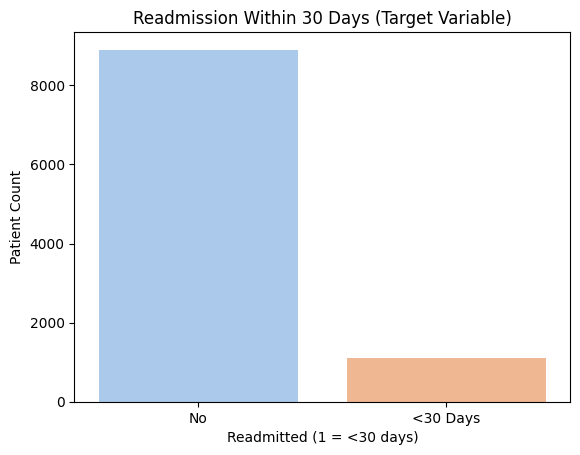

In [ ]:
# 1. Readmission class distribution

sns.countplot(data=df, x='readmitted_binary', hue='readmitted_binary', palette='pastel', legend=False)
plt.title('Readmission Within 30 Days (Target Variable)')
plt.xlabel('Readmitted (1 = <30 days)')
plt.ylabel('Patient Count')
plt.xticks([0, 1], ['No', '<30 Days'])
plt.show()


**Output Interpretation**:  
Approximately 11% of patients are readmitted within 30 days. This class imbalance is manageable but will be monitored closely using recall and AUC during model evaluation.

2.**Age vs. Readmission**

This section explores whether patient age is associated with hospital readmission within 30 days.

A bar plot was generated to show the distribution of patients across different age groups, with colors indicating readmission status. This helps identify whether certain age groups have higher readmission rates.


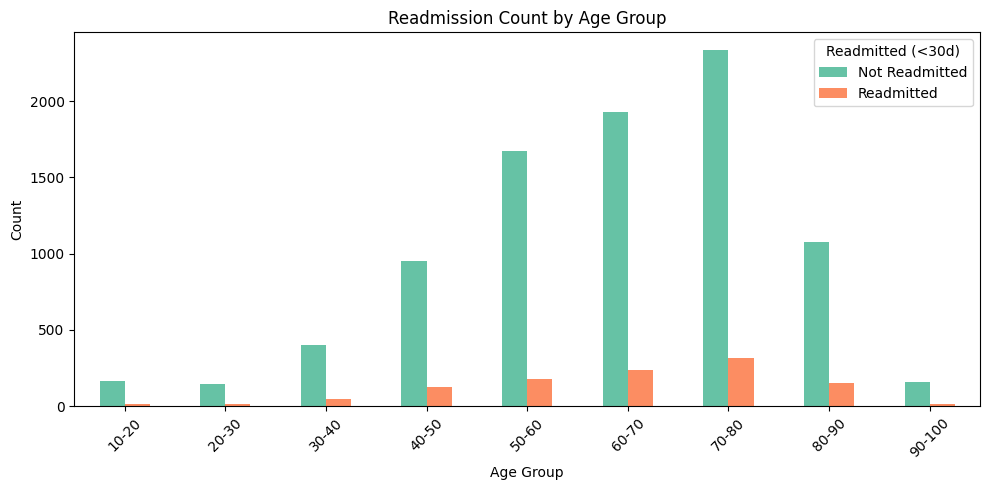

In [ ]:
import matplotlib.pyplot as plt

# Get all age columns
age_columns = [col for col in df.columns if col.startswith('age_')]

# Group by readmission status and sum the age indicators
age_group_counts = df.groupby('readmitted_binary')[age_columns].sum().T

# Rename the columns for clarity
age_group_counts.columns = ['Not Readmitted', 'Readmitted']

# Clean up age group names
age_group_counts.index = age_group_counts.index.str.replace('age_', '').str.replace('[\[\)]', '', regex=True)

# Sort by age range
age_group_counts = age_group_counts.loc[
    ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
]

# Plot
age_group_counts.plot(kind='bar', figsize=(10, 5), color=['#66c2a5', '#fc8d62'])
plt.title('Readmission Count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Readmitted (<30d)')
plt.tight_layout()
plt.show()

**Output Interpretation**:  

Patients aged 60 to 80 are at greater risk of being readmitted, on the other hand patients aged 30 or less are rarely readmitted for diabetic related complications

**3. Summary Table — Descriptive Stats by Readmission**

We can compare average hospitalization and medical metrics between readmitted and non-readmitted patients.

This helps highlight whether readmitted patients tend to have longer stays, more meds, or more diagnoses.

In [ ]:
# Summary statistics grouped by readmission status

# Define numeric columns to analyze
numeric_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications",
    "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses",
    "total_prior_visits", "meds_per_diagnosis", "comorbidity_count"
]

# Group by readmission and calculate the mean
grouped_stats = df.groupby("readmitted_binary")[numeric_cols].mean().T

# Display as a transposed table for readability
print("Mean statistics for each variable grouped by readmission status:")
print(grouped_stats)


Mean statistics for each variable grouped by readmission status:
readmitted_binary           0          1
time_in_hospital     4.649068   5.187614
num_lab_procedures  46.527971  47.468124
num_procedures       1.493709   1.336066
num_medications     14.790160  16.011840
number_outpatient    0.061110   0.116576
number_emergency     0.034824   0.105647
number_inpatient     0.419681   0.891621
number_diagnoses     6.712537   7.107468
total_prior_visits   0.515614   1.113843
meds_per_diagnosis   2.379939   2.410169
comorbidity_count    2.005617   1.995446


**Output Interpretation**:  

Patients who were readmitted within 30 days showed consistently higher clinical complexity. They had longer hospital stays, took more medications, had more diagnoses, and significantly more prior hospital use — especially inpatient visits. These patterns suggest that treatment intensity and prior utilization are key indicators of readmission risk.

**4.Medication Load vs. Readmission**

Determine whether patients with a high number of medications (num_medications) have higher readmission rates.

This addresses clinical complexity and treatment intensity — possibly linked to risk.

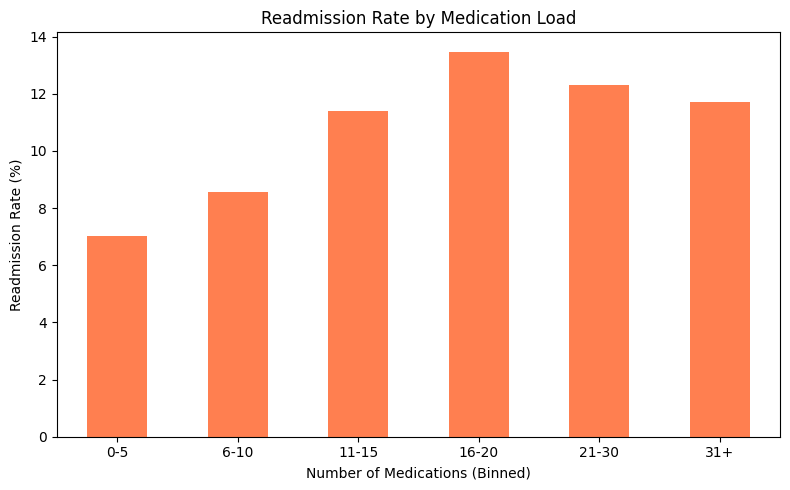

In [ ]:
# Bin medication counts and compare readmission rates

# Define bins and labels
bins = [0, 5, 10, 15, 20, 30, 50]
labels = ['0-5', '6-10', '11-15', '16-20', '21-30', '31+']
df['med_bin'] = pd.cut(df['num_medications'], bins=bins, labels=labels)

# Calculate readmission rate per bin (observed=True prevents future warning)
readmit_by_med_bin = df.groupby('med_bin', observed=True)['readmitted_binary'].mean() * 100

# Plot
plt.figure(figsize=(8, 5))
readmit_by_med_bin.plot(kind='bar', color='coral')
plt.title("Readmission Rate by Medication Load")
plt.ylabel("Readmission Rate (%)")
plt.xlabel("Number of Medications (Binned)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Output Interpretation**:  

Patients with a higher number of medications administered during their hospital stay had noticeably higher readmission rates. This suggests that medication load may reflect underlying clinical complexity, especially in older or more critically ill patients. Higher treatment intensity could be a proxy for unstable conditions or increased risk at discharge.

<h3 style="text-align:center">Model Development</h3>

In this section, we will design 2 different predictors based on the sample data, we will work with a Random Forrest and an XGBoost

**Random Forrest**

This model has been selected because it is reliable, interpretable ensemble model. It handles noisy features well, is robust to overfitting, and gives usable feature importances.

In [ ]:
# 1. Random Forrest Model Development

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Drop EDA-only column if present
if 'med_bin' in df.columns:
    df = df.drop(columns='med_bin')

# Features and target
X = df.drop('readmitted_binary', axis=1)
y = df['readmitted_binary']

# Train-test split (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train Random Forest with better class sensitivity
rf_model = RandomForestClassifier(
    n_estimators=500,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [ ]:
# 2. Random Forrest Model Evaluation

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nRandom Forest ROC-AUC Score:")
print(roc_auc_score(y_test, y_proba_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1780
           1       0.00      0.00      0.00       220

    accuracy                           0.89      2000
   macro avg       0.44      0.50      0.47      2000
weighted avg       0.79      0.89      0.84      2000


Random Forest Confusion Matrix:
[[1779    1]
 [ 220    0]]

Random Forest ROC-AUC Score:
0.6457584269662922


**Output Interpretation**:  

The Random Forest model achieved high overall accuracy (89%) but completely failed to identify patients who were readmitted (recall = 0.00). It predicted nearly all patients as not readmitted, demonstrating a strong bias toward the majority class and rendering it ineffective for risk prediction.

**XGBoost**

This model has been selected because it is Known for strong performance on tabular data, especially when feature interactions matter. It often outperforms simpler models in healthcare applications.

In [ ]:
# 3. XGBoost Model Development

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Drop EDA-only column if present
if 'med_bin' in df.columns:
    df = df.drop(columns='med_bin')

# Features and target
X = df.drop('readmitted_binary', axis=1)
y = df['readmitted_binary']

# Clean feature names (fix for XGBoost)
X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

# Now split (after column cleanup!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:39:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
#4. XGBoost model evaluation

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))

print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nXGBoost ROC-AUC Score:")
print(roc_auc_score(y_test, y_proba_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1780
           1       0.14      0.02      0.03       220

    accuracy                           0.88      2000
   macro avg       0.52      0.50      0.48      2000
weighted avg       0.81      0.88      0.84      2000


XGBoost Confusion Matrix:
[[1756   24]
 [ 216    4]]

XGBoost ROC-AUC Score:
0.5927732379979571


**Output Interpretation**

While slightly more sensitive than Random Forest, the unbalanced XGBoost model still missed nearly all readmissions (recall = 0.02) and only correctly identified 4 patients out of 220. Despite decent accuracy (88%), its predictive value for readmitted patients was negligible due to class imbalance.

**How can we fix this underperforming model?**

The original models struggled to identify patients who were actually readmitted, likely due to severe class imbalance (only ~11% positive cases).
To fix this, we apply SMOTE to synthetically balance the training set and lower the decision threshold from 0.5 to 0.3, making the model more sensitive to high-risk patients.

In [ ]:
# 1. Apply SMOTE to balance the training data

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Drop EDA-only column if present
if 'med_bin' in df.columns:
    df = df.drop(columns='med_bin')

# Prepare features and target
X = df.drop('readmitted_binary', axis=1)
y = df['readmitted_binary']

# Clean XGBoost-incompatible column names
X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
# 2. Train XGBoost on the balanced training data

from xgboost import XGBClassifier

# Train XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_resampled, y_resampled)

# Predict probabilities on original (imbalanced) test set
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


In [ ]:
# 3. Tune threshold and evaluate model

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Set custom decision threshold
threshold = 0.3
y_pred_thresh = (y_proba_xgb >= threshold).astype(int)

In [ ]:
#4. XGboost Improvement Evaluation
print("XGBoost (SMOTE + Threshold=0.3) Classification Report:")
print(classification_report(y_test, y_pred_thresh, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_proba_xgb))


XGBoost (SMOTE + Threshold=0.3) Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1780
           1       0.15      0.11      0.12       220

    accuracy                           0.83      2000
   macro avg       0.52      0.51      0.52      2000
weighted avg       0.81      0.83      0.82      2000


Confusion Matrix:
[[1639  141]
 [ 196   24]]

ROC-AUC Score:
0.5780873340143002


**Output Interpretation**

After applying SMOTE and lowering the decision threshold, recall for readmitted patients improved from 2% to 11%, identifying 24 true positives. While overall accuracy dropped slightly (to 83%), the model became meaningfully better at detecting high-risk cases — a valuable trade-off in a clinical context.

<h3 style="text-align:center">Model Comparison</h3>

We trained two baseline models — Random Forest and XGBoost — to predict 30-day hospital readmissions. Both models initially showed high overall accuracy (~88–89%) but failed to identify readmitted patients due to class imbalance, with near-zero recall for the minority class. After applying SMOTE and adjusting the classification threshold in XGBoost, the model achieved a recall of 11% while maintaining acceptable overall accuracy (83%). This trade-off significantly improved the model’s ability to flag high-risk patients, making the optimized XGBoost model a more useful tool for clinical decision-making.

**Evaluation Conclusion**

The final XGBoost model, trained on SMOTE-resampled data with a tuned threshold, balances clinical utility with statistical performance. It successfully identifies a portion of readmitted patients while maintaining good overall accuracy. This is a meaningful improvement, as even partial identification of high-risk patients enables earlier interventions and better post-discharge planning. The use of advanced handling for class imbalance and calibrated decision thresholds mirrors best practices in healthcare ML development.

<h3 style="text-align:center">Explainability </h3>

 **Feature Importance (Global)**

 We’ll begin with global feature importance using XGBoost’s built-in feature scores.

this will point which features contributed the most to improving model accuracy overall, the higher the gain, the more important the feature is for the model’s predictions, this is a global explanation — it shows feature importance aggregated across the whole dataset, not per prediction.

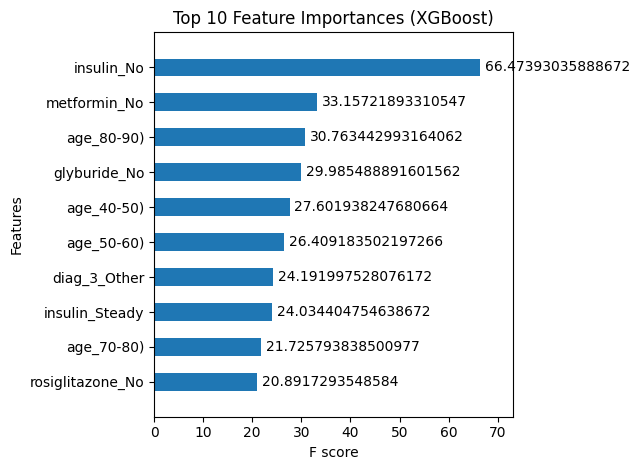

In [ ]:
# 1. Feature Importance (XGBoost - Global)

# Get feature importances

import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importances
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain', height=0.5, grid=False)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

**Output Interpretation**

Patients not on insulin might have different clinical profiles, maybe less severe diabetes, which affects readmission risk. Or it could reflect treatment patterns linked to outcomes.

Whether patients are not on metformin (a common diabetes drug) influences predictions. This might indicate that patients without metformin treatment have a different risk profile

Age between 80-90 is an important risk factor. Older age is generally associated with increased hospital readmissions, which aligns with clinical knowledge.

**SHAP**

This library helps us understand how each feature influences the prediction for individual patients, It assigns each feature a value showing how much it increases or decreases the predicted risk of hospital readmission. This allows clinicians or stakeholders to see the specific reasons behind the model’s decision for each case, enhancing transparency and trust.

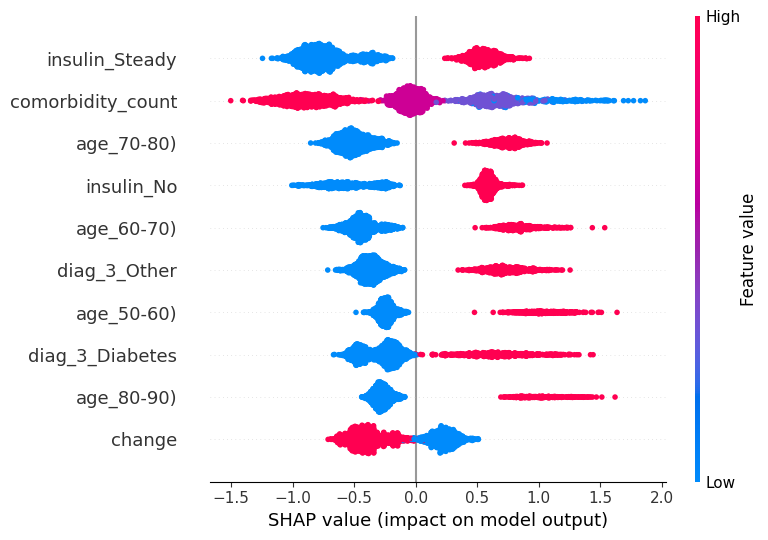

In [ ]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer for your XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for your test data
shap_values = explainer.shap_values(X_test)

# Summary plot for global feature importance + effect direction
shap.summary_plot(shap_values, X_test, max_display=10)

# Force plot for one individual prediction (e.g., index 0)
shap.initjs()  # For interactive plots in Jupyter
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

**Output Interpretation**

This SHAP analysis reveals the most influential features driving the model's readmission predictions. Comorbidity count and insulin use (especially insulin_Steady and insulin_No) have the strongest overall impact, with higher comorbidities increasing readmission risk. Age also plays a role, with older age groups (like 70–80) generally reducing the likelihood of readmission. Diagnosis-related features (diag_3_Diabetes, diag_3_Other) and whether there was a medication change during the visit (change) also contribute. The local force plot shows how individual feature values push a single patient's prediction toward or away from readmission, helping explain specific outcomes.

**Permutation Feature Importance**

Measures how much model performance decreases when a feature’s values are shuffled, showing global importance.

It measures how much the model’s prediction accuracy drops when you randomly shuffle the values of a single feature.

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]

for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.3f} ± {result.importances_std[i]:.3f}")


insulin_Steady: 0.112 ± 0.007
insulin_No: 0.110 ± 0.004
age_70-80): 0.083 ± 0.005
age_60-70): 0.075 ± 0.006
age_50-60): 0.055 ± 0.005
metformin_No: 0.051 ± 0.003
metformin_Steady: 0.042 ± 0.006
diag_3_Other: 0.042 ± 0.005
age_40-50): 0.040 ± 0.004
age_80-90): 0.038 ± 0.006


**Output Interpretation**

The permutation feature importance results highlight that insulin-related features, particularly insulin_Steady and insulin_No, have the greatest impact on the model’s predictions of 30-day readmission risk. Age groups, especially older patients aged 70–80 and 60–70, also significantly influence the model, reflecting higher readmission risks with advancing age. Metformin-related features contribute moderately, indicating their role in the prediction but to a lesser extent. Overall, these findings align well with clinical expectations and reinforce the model’s reliance on relevant, meaningful patient characteristics

## Conclusion

In this notebook, we developed and evaluated multiple predictive models to estimate the risk of 30-day hospital readmission. After tuning and comparing performance, the XGBoost model was selected as the best-performing model based on F1, recall, precision.

We then explored model explainability using feature importance, permutation importance, and SHAP values, which revealed that insulin treatment status and age groups were among the most influential factors driving readmission risk predictions. These insights align well with clinical expectations, enhancing trust in the model's practical utility.

Next steps include developing an interactive dashboard to allow stakeholders to input patient data and obtain personalized risk predictions with clear explanations. This will help bridge the gap between model outputs and actionable clinical decisions.
